# Numerical simulations related to the paper *Pricing under rough volatility*

#### Useful imports

In [ ]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as ssn
import scipy.optimize

# Simulation of the rBergomi model

### Parameters

#### Real model parameters: $H$, $\eta$ and $\rho$

In [ ]:
H = 0.1 # Hurst exponent of the underlying fractional brownian motion
eta = 1
rho = 0.5 # correlation constant between Z (brownian motion driving the price process of the asset S) and W (brownian motion driving volatility's evolution)

#### Additional parameter: $\xi_0(u)$

In [ ]:
xi0 = 1 # xi0(u) is assumed to be constant

#### Computed constants for the purpose of this simulation

In [ ]:
T = 1 # time scale (1 year)
m = 100  # number of time steps between 0 and T
delta = T / m # duration of a time step
gamma = 0.5 - H
DH = ((2 * H) ** 0.5) / (H + 0.5)
time = np.array([i * delta for i in range (m + 1)])
v0 = xi0
S0 = 1

### Simulation of $W$ and $Z$

#### Auxiliary functions

In [ ]:
def G(z):
    return ((1 - 2 * gamma) / (1 - gamma)) * (z ** gamma) * sc.hyp2f1(1, gamma, 2 - gamma, z)

In [ ]:
def compute_covariance_Wu_Wv(u, v): # supposing u less or equal than v. Note that G(1) = 1
  if (u == 0): return 0
  return (u ** (2 * H)) * G (u / v)

In [ ]:
def compute_covariance_Wu_Zv(u, v): # computing covariance bewteen Wu and Zv!
  return rho * DH * (u ** (H + 0.5) - (u - min(u, v)) ** (H + 0.5))

In [ ]:
def compute_covariance_matrix_W_Z():
  # Initialization
  cov = np.zeros((2 * m, 2 * m))

  # Covariances between Wu and Wv
  for i in range (m):
    for j in range (i, m):
      u, v = (i + 1) * delta, (j + 1) * delta
      cov[i, j] = compute_covariance_Wu_Wv(u, v) # u is indeed less than v
      cov[j, i] = cov[i, j]

  # Covariances between Wu and Zv
  for i in range (m):
    for j in range (m, 2 * m):
      u, v = (i + 1) * delta, (j + 1 - m) * delta
      cov[i, j] = compute_covariance_Wu_Zv(u, v)
      cov[j, i] = cov[i, j]

  # Covariances between Zu and Zv
  for i in range (m, 2 * m):
    for j in range (i, 2 * m):
      u, v = (i + 1 - m) * delta, (j + 1 - m) * delta # v is greater than u (or equal)
      cov[i, j] = u
      cov[j, i] = cov[i, j]

  return cov

#### Effective simulation of $W$ and $Z$

In [ ]:
def generate_cholesky():
  cov = compute_covariance_matrix_W_Z()
  # Cholesky decomposition
  return np.linalg.cholesky(cov)

In [ ]:
def generate_WZ(cholesky):
    WZ = np.random.normal(0, 1, 2 * m)
    WZ = cholesky @ WZ
    return WZ[:m], WZ[m:]

### Simulation of $v$ and $S$


In [ ]:
def generate_matrix_add_zero(): # Rajoute 0 en haut d'un vecteur (m, 1)
  matrix_add_zero = np.zeros((m + 1, m))
  for i in range (1, m + 1):
    matrix_add_zero[i, i - 1] = 1
  return matrix_add_zero

matrix_add_zero = generate_matrix_add_zero()

In [ ]:
def generate_v(W, Z):
  variance_W = np.array([(i * delta) ** (2 * H) for i in range (m + 1)])
  return xi0 * np.exp(eta * (matrix_add_zero @ W) - 0.5 * (eta ** 2) * variance_W) # TO BE CHECKED

In [ ]:
def generate_matrix_differences(): # this matrix M will have shape (m, m), so that M multiplied by Z will give [Z1 - Z0, ..., Zm - Z(m-1)] with Z0 = 0
  diff_matrix = np.zeros((m, m))
  for i in range (1, m):
    diff_matrix[i, i] = 1
    diff_matrix[i, i - 1] = -1
  diff_matrix[0, 0] = 1
  return diff_matrix

diff_matrix = generate_matrix_differences()

In [ ]:
def generate_inverse_matrix_differences(): # this matrix M will have shape (m + 1, m), so that M multiplied by [X1 - X0, ..., Xm - X(m-1)] will give [0, X1 - X0, X2 - X0, ..., Xm - X0]
  diff_matrix_inverse = np.zeros((m + 1, m))
  for i in range (1, m + 1):
    for j in range (i):
      diff_matrix_inverse[i, j] = 1
  return diff_matrix_inverse

diff_matrix_inverse = generate_inverse_matrix_differences()

In the following code, $X_t$ denotes $\log{S_t}$.

In [ ]:
def generate_S(W, Z, v): # v is necessary to generate S
    ## Using an Euler Scheme to generate S
    dX = - 0.5 * delta * v[:m]  + np.sqrt(v[:m]) * (diff_matrix @ Z) # dX = [X1 - X0, ..., Xm - X(m-1)]
    X = diff_matrix_inverse @ dX + np.log(S0) * np.ones((m + 1)) # X = [X0, ..., Xm]
    S = np.exp(X)
    return S

In [ ]:
def generate_vS(cholesky):
  W, Z = generate_WZ(cholesky)
  v = generate_v(W, Z)
  S = generate_S(W, Z, v)
  return v, S

In [ ]:
def plot_vS(cholesky):
  v, S = generate_vS(cholesky)
  plt.plot(time, S, label=r'Price of asset $S$')
  plt.xlabel(r"Time $t$")
  plt.plot(time, v, label=r'Volatility $v$')
  plt.xlabel(r"Time $t$")
  plt.legend()
  plt.show()

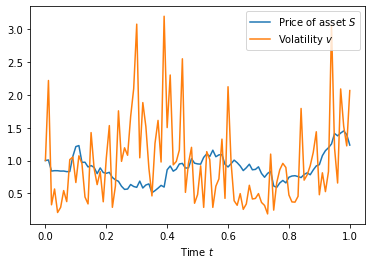

In [ ]:
plot_vS(generate_cholesky())

### Pricing of European options

In [ ]:
def expected_payoff_Monte_Carlo(cholesky, number_simulations, K, maturity): # K is the strike, and number_simulations is the number of simulations. One maturity and one strike
    time_step = min(int((maturity / T) * (m + 1)), m) # must be less or equal to m
    sum_payoff = 0
    for _ in tqdm(range(number_simulations)):
        v, S = generate_vS(cholesky)
        sum_payoff += max(0, S[time_step] - K)
    return sum_payoff / number_simulations

In [ ]:
expected_payoff_Monte_Carlo(generate_cholesky(), 5000, 0.9, 1)

  0%|          | 0/5000 [00:00<?, ?it/s]

0.3703938845263227

In [ ]:
def expected_payoff_Monte_Carlo_reusing_simulations(cholesky, number_simulations, list_K, maturity): #list_K is the list of strikes. One maturity and a list of strikes
  time_step = min(int((maturity / T) * (m + 1)), m) # must be less or equal to m
  sum_payoff = np.zeros(list_K.shape[0])
  for _ in tqdm(range(number_simulations)):
      v, S = generate_vS(cholesky)
      sum_payoff += np.maximum(0, S[time_step] - list_K)
  return sum_payoff / number_simulations # returns a list of option prices corresponding to the same maturity but different strikes

In [ ]:
expected_payoff_Monte_Carlo_reusing_simulations(generate_cholesky(), 10000, np.array([0.5, 1., 1.5]), 1)

  0%|          | 0/10000 [00:00<?, ?it/s]

array([0.57510587, 0.37701261, 0.27785903])

In [ ]:
def expected_payoff_Monte_Carlo_reusing_simulations_different_maturities(cholesky, number_simulations, list_K, maturities): #list_K is the list of strikes. A list of maturities, and a list of strikes for each maturity
  number_maturities, number_K = list_K.shape
  time_step = np.minimum(np.floor((maturities / T) * (m + 1)), m) # must be less or equal to m
  sum_payoff = np.zeros((number_maturities, number_K))
  for _ in tqdm(range(number_simulations)):
      v, S = generate_vS(cholesky)
      for i in range (number_maturities):
        sum_payoff[i] += np.maximum(0, S[int(time_step[i])] - list_K[i])
  return sum_payoff / number_simulations # returns a list of option prices corresponding to the same maturity but different strikes

In [ ]:
expected_payoff_Monte_Carlo_reusing_simulations_different_maturities(generate_cholesky(), 10000, np.array([[0.1, 0.2], [0.2, 0.25]]), np.array([0.1, 0.12]))

  0%|          | 0/10000 [00:00<?, ?it/s]

array([[0.89938026, 0.79938026],
       [0.79938026, 0.74938026]])

### Estimation of implied volatility

#### Black-Scholes model

In [ ]:
def black_scholes(volatility, K, maturity): # K is the strike, t is the maturity
    v = maturity * (volatility ** 2)
    dplus = np.log(S0 / K) / (v ** 0.5) + 0.5 * (v ** 0.5)
    dminus = np.log(S0/K) / (v ** 0.5) - 0.5 * (v ** 0.5)
    return S0 * ssn.norm.cdf(dplus) - K * ssn.norm.cdf(dminus)

In [ ]:
def plot_black_scholes(K):
  volatilities = np.array([i / 100 for i in range (1, 1001)])
  options = np.array([black_scholes(volatility, K, 1) for volatility in volatilities])
  plt.xlabel(r"Volatility $\sigma_{BS}$")
  plt.ylabel(r"Price of the European option with volatility $v$ and strike $K = " + str(K) +"$")
  plt.plot(volatilities, options)
  plt.show()

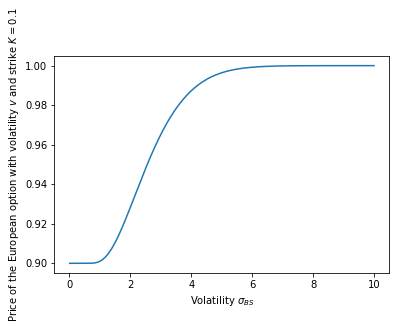

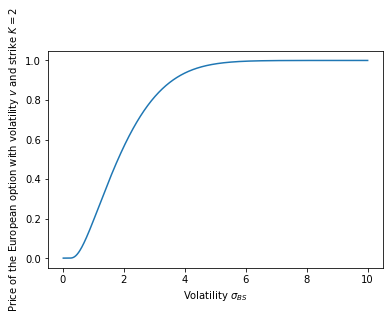

In [ ]:
plot_black_scholes(0.1)
plot_black_scholes(2)

#### Inverting Black-Scholes

In [ ]:
def invert_black_scholes(K, maturity, option_price, inf_volatility = 1e-15, sup_volatility = 10):
  f = lambda volatility : black_scholes(volatility, K, maturity) - option_price
  return scipy.optimize.bisect(f, inf_volatility, sup_volatility)

In [ ]:
print(invert_black_scholes(0.1, 1., 0.92, 1e-5, 10))
print(invert_black_scholes(0.1, 1., 0.94, 1e-5, 10))
# Consistent with above graphs

1.7846306732548185
2.295332354471053


### Estimation of $\sigma_{BS}(k, t)$ (implied volatility when pricing a European option with log-strike $k$ and maturity $t \in [0, 1]$ with rBergomi model with parameters $H$, $\eta$ and $\rho$)

In [ ]:
def implied_volatility(cholesky, k, maturity, number_simulations): # number_simulations is the number of simulations for Monte Carlo pricing. One log-strike and one maturity
  K = S0 * np.exp(k)
  option_price = expected_payoff_Monte_Carlo(cholesky, number_simulations, K, maturity)
  return invert_black_scholes(K, maturity, option_price)

In [ ]:
implied_volatility(generate_cholesky(), 0.1, 1, 100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

1.023071920961912

In [ ]:
def implied_volatility_reusing_simulations(cholesky, list_k, maturity, number_simulations): # One maturity and a list of strikes
  list_K = S0 * np.exp(list_k)
  option_prices = expected_payoff_Monte_Carlo_reusing_simulations(cholesky, number_simulations, list_K, maturity)
  return np.array([invert_black_scholes(list_K[i], maturity, option_prices[i]) for i in range (list_K.shape[0])])

In [ ]:
implied_volatility_reusing_simulations(generate_cholesky(), np.array([0.1, 0.2, 0.3]), 1, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

array([4.99036278e-02, 5.10530185e-02, 1.00000000e-15])

In [ ]:
def implied_volatility_reusing_simulations_different_maturities(cholesky, list_k, maturities, number_simulations): # A list of maturities and a list of strikes for each maturity
  number_maturities, number_K = list_k.shape
  list_K = S0 * np.exp(list_k)
  option_prices = expected_payoff_Monte_Carlo_reusing_simulations_different_maturities(cholesky, number_simulations, list_K, maturities)
  return np.array([[invert_black_scholes(list_K[i, j], maturities[i], option_prices[i, j]) for j in range (number_K)] for i in range (number_maturities)])

In [ ]:
implied_volatility_reusing_simulations_different_maturities(generate_cholesky(), np.array([[0.1, 0.2], [0.1, 0.2]]), np.array([0.5, 1.0]), 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

array([[0.07071769, 0.09214387],
       [0.05000496, 0.06515555]])

In [ ]:
def plot_implied_volatility(maturity, inf_k, sup_k, number_k, number_simulations): # number_simulations is the number of simulations for Monte Carlo pricing, number_k is the number of k for which we are launching those simulations
  cholesky = generate_cholesky()
  list_k = np.linspace(inf_k, sup_k, number_k)
  implied_volatilities = np.array([implied_volatility(cholesky, k, maturity, number_simulations) for k in list_k])
  plt.xlabel(r"Log-strike $k$")
  plt.ylabel(r"Implied volatility $\sigma_{BS}(k, T)$ with $T = " + str(maturity) + "$")
  plt.plot(list_k, implied_volatilities)
  plt.show()

In [ ]:
def plot_implied_volatility_reusing_simulations(maturity, inf_k, sup_k, number_k, number_simulations): # number_simulations is the number of simulations for Monte Carlo pricing, number_k is the number of k for which we are launching those simulations
  # one maturity and a list of strikes
  cholesky = generate_cholesky()
  list_k = np.linspace(inf_k, sup_k, number_k)
  implied_volatilities = implied_volatility_reusing_simulations(cholesky, list_k, maturity, number_simulations)
  plt.xlabel(r"Log-strike $k$")
  plt.ylabel(r"Implied volatility $\sigma_{BS}(k, T)$ with $T = " + str(maturity) + "$")
  plt.plot(list_k, implied_volatilities)
  plt.show()

In [ ]:
def plot_implied_volatility_reusing_simulations_different_maturities(maturities, list_inf_k, list_sup_k, number_k, number_simulations): # number_simulations is the number of simulations for Monte Carlo pricing, number_k is the number of k for which we are launching those simulations
  # A list of maturities and a list of strikes for each maturity
  cholesky = generate_cholesky()
  number_maturities = maturities.shape[0]
  list_k = np.array([np.linspace(list_inf_k[i], list_sup_k[i], number_k) for i in range (number_maturities)])
  implied_volatilities = implied_volatility_reusing_simulations_different_maturities(cholesky, list_k, maturities, number_simulations)

  plt.figure(figsize = (20, 10))

  for i in range (number_maturities):
    plt.subplot(2, 4, i + 1)
    plt.xlabel(r"Log-strike $k$")
    plt.ylabel(r"Implied volatility $\sigma_{BS}(k, T)$")
    plt.title(r"$T = " + str(maturities[i]) + "$")
    plt.plot(list_k[i], implied_volatilities[i])
  plt.show()

### Plotting ATM (at-the-money) volatility skew $\psi(\tau)$

#### Plotting $\psi(\tau) = f(\tau)$

In [ ]:
def plot_at_the_money_skew_reusing_simulations(min_maturity, max_maturity, number_maturities, epsilon, number_simulations):
  # maturities is a list of maturities, epsilon is the value of k used to compute the derivative at k = 0...
  cholesky = generate_cholesky()
  maturities = np.linspace(min_maturity, max_maturity, number_maturities)
  list_k = np.array([[-epsilon, epsilon] for _ in range (number_maturities)])
  implied_volatilities = implied_volatility_reusing_simulations_different_maturities(cholesky, list_k, maturities, number_simulations)
  skews = np.abs(implied_volatilities[:, 1] - implied_volatilities[:, 0]) / (2 * epsilon)

  plt.xlabel(r"Maturity $\tau$")
  plt.ylabel(r"At the money volatility skew $\psi(\tau)$")
  plt.plot(maturities, skews)
  plt.show()

#### Plotting $\log(\psi(\tau)) = f(\log(\tau))$

In [ ]:
def plot_log_at_the_money_skew_reusing_simulations(min_maturity, max_maturity, number_maturities, epsilon, number_simulations):
  # maturities is a list of maturities, epsilon is the value of k used to compute the derivative at k = 0...
  cholesky = generate_cholesky()
  maturities = np.linspace(min_maturity, max_maturity, number_maturities)
  list_k = np.array([[-epsilon, epsilon] for _ in range (number_maturities)])
  implied_volatilities = implied_volatility_reusing_simulations_different_maturities(cholesky, list_k, maturities, number_simulations)
  skews = np.abs(implied_volatilities[:, 1] - implied_volatilities[:, 0]) / (2 * epsilon)

  plt.xlabel(r"Log-maturity $\log(\tau)$")
  plt.ylabel(r"At the money volatility log-skew $\log(\psi(\tau))$")
  plt.plot(np.log(maturities), np.log(skews), label = "rBergomi model", color = "blue")

  # Linear regression
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(maturities), np.log(skews))
  plt.plot(np.log(maturities), np.log(maturities) * slope + intercept, label = r"Linear regression: $" + str(round(slope, 3)) + "\log(\\tau) + (" + str(round(intercept, 3)) + ")$", color = "red", linestyle = "dashed")
  plt.legend(loc = 'best')
  plt.show()
  print("r = ", r_value)

### Reproducing plots from the article

#### $T = 0.041$, $k \in [-0.3, 0.1]$, $H = 0.07$, $\eta = 1.9$, $\rho = -0.9$

In [ ]:
H = 0.07
eta = 1.9
rho = -0.9
xi0 = 0.14
T = 0.041
m = 100  # number of time steps between 0 and T
delta = T / m # duration of a time step
gamma = 0.5 - H
DH = ((2 * H) ** 0.5) / (H + 0.5)
time = np.array([i * delta for i in range (m + 1)])
v0 = xi0
S0 = 1

In [ ]:
# plot_implied_volatility(0.041, -0.3, 0.2, 20, 10000)

In [ ]:
# plot_implied_volatility_reusing_simulations(0.041, -0.3, 0.2, 20, 100000)

$H = 0.07$, $\eta = 1.9$, $\rho = -0.9$ (page 19)

In [ ]:
H = 0.07
eta = 1.9
rho = -0.9
xi0 = 0.13
T = 0.4
m = 100  # number of time steps between 0 and T
delta = T / m # duration of a time step
gamma = 0.5 - H
DH = ((2 * H) ** 0.5) / (H + 0.5)
time = np.array([i * delta for i in range (m + 1)])
v0 = xi0
S0 = 1

In [ ]:
# maturities = np.array([0.041, 0.12, 0.15, 0.19, 0.29, 0.37, 0.40, 0.62, 0.65, 0.87, 0.90, 1.36, 1.86, 2.88])
# list_inf_k = np.array([-0.3, -0.5, -0.45, -0.45, -0.6, -1.0, -0.8, -1.0, -0.8, -1.7, -0.9, -1.7, -2.5, -2.5])
# list_sup_k = np.array([0.15, 0.2, 0.15, 0.2, 0.25, 0.3, 0.25, 0.25, 0.3, 0.65, 0.4, 0.5, 0.7, 0.7])

In [ ]:
maturities = np.array([0.041, 0.12, 0.15, 0.19, 0.29, 0.37, 0.40])
list_inf_k = np.array([-0.3, -0.5, -0.45, -0.45, -0.6, -1.0, -0.8])
list_sup_k = np.array([0.15, 0.2, 0.15, 0.2, 0.25, 0.3, 0.25])

  0%|          | 0/100000 [00:00<?, ?it/s]

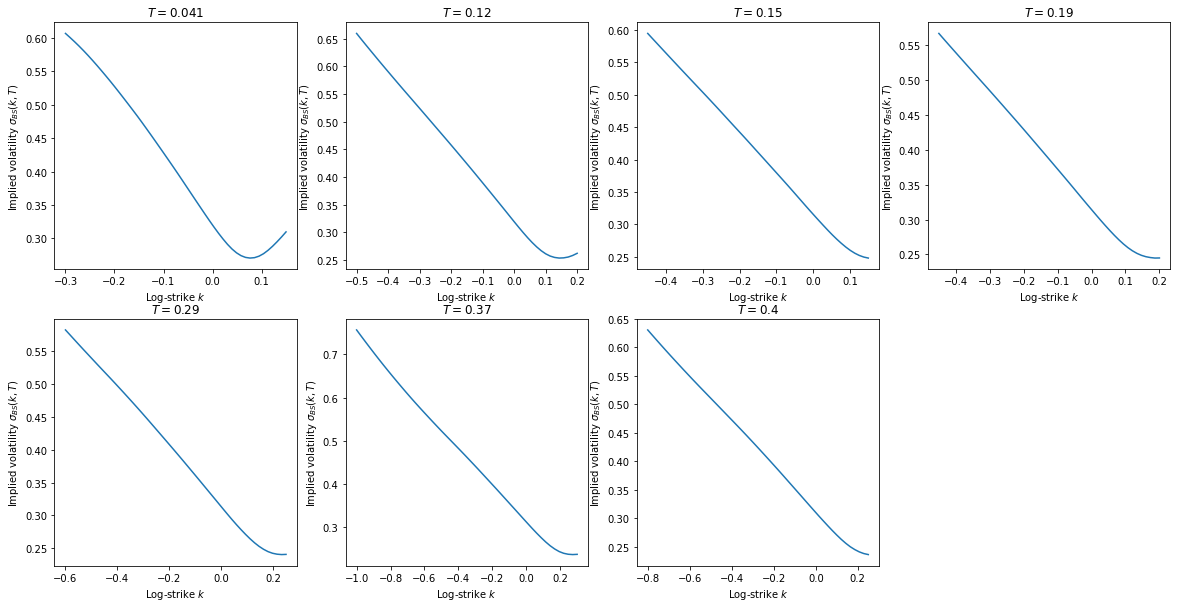

In [ ]:
plot_implied_volatility_reusing_simulations_different_maturities(maturities, list_inf_k, list_sup_k, 50, 100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

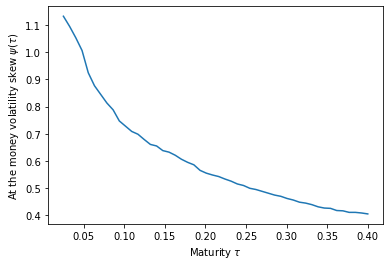

In [ ]:
plot_at_the_money_skew_reusing_simulations(0.025, 0.4, 50, 1e-9, 100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

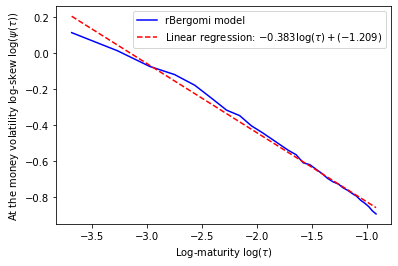

r =  -0.9955968761587414


In [ ]:
plot_log_at_the_money_skew_reusing_simulations(0.025, 0.4, 30, 1e-9, 100000)